In [137]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.spatial import distance  


In [200]:
class RegularIrrigationSim:
    def __init__(self, theta0, starts, lam, sigma_theta):
        self.soil_moist = theta0 * np.dot(np.ones_like(starts), 0 >= starts)
        self.theta0 = theta0
        self.lam = lam
        self.sigma_theta = sigma_theta
        self.time = 0.0
        self.starts = starts
        self.data = {
            'latent' : {
                't' : [0.0],
                'y' : [self.soil_moist]
            },
            'observed' : {
                't' : [],
                'y' : []
            }
        }
    
    def update(self, dt):
        self.soil_moist = self.theta0 * np.dot(np.exp(-self.lam * (self.time - self.starts)), self.time >= self.starts)
        self.time += dt
        self.data['latent']['t'].append(self.time)
        self.data['latent']['y'].append(self.soil_moist)

    def observation(self):
        self.data['observed']['t'].append(self.time)
        self.data['observed']['y'].append(self.soil_moist * np.exp(np.random.normal(0, self.sigma_theta)))

In [462]:
from abc import ABC, abstractmethod

class kernel: 
    
    def __call__(self, X=None, Xobs=None): 
        return self.covariance(X, Xobs) 
    
    def __add__(self, other): 
        return SumKernel(self, other)    
    
    def __mul__(self, other): 
        return MultKernel(self, other) 
    
    @abstractmethod
    def covariance(self): 
        pass 

    def compute_distance_matrix(self, X, Xobs): 
        if X is None: 
            D = self.D 
        else:
            if Xobs is None: 
                D = distance.cdist(X, X, metric='euclidean')
            else: 
                D = distance.cdist(X, Xobs, metric='euclidean')
        return D  


class SumKernel(kernel):
    def __init__(self, k1, k2):
        self.k1 = k1
        self.k2 = k2
    
    def covariance(self, X=None, Xobs=None):
        # Just sum the covariances from the two kernels
        return self.k1(X, Xobs) + self.k2(X, Xobs)
    
class MultKernel(kernel): 
    def __init__(self, k1, k2):
        self.k1 = k1
        self.k2 = k2
    
    def covariance(self, X=None, Xobs=None):
        # Just sum the covariances from the two kernels
        return self.k1(X, Xobs) * self.k2(X, Xobs)


class exponential_kernel(kernel): 
    def __init__(self, lengthscale, variance):
        self.L = lengthscale
        self.V = variance 
    
    def covariance(self, X = None, Xobs = None):
        
        D = self.compute_distance_matrix(X, Xobs) 
        cov_dist = ((D / self.L)**2) 
        
        return self.V * np.exp(-cov_dist)
    
class periodic_kernel(kernel): 
    def __init__(self, roughness, period, variance):
        self.W = roughness 
        self.T = period 
        self.V = variance
    
    def covariance(self, X = None, Xobs = None): 

        D = self.compute_distance_matrix(X, Xobs) 
        
        periodicity = (np.pi * (D / self.T))
        cov = (2 / self.W ** 2) * (np.sin(periodicity) ** 2)
        
        return self.V * np.exp(-cov) 

class decay_kernel(kernel): 
    def __init__(self, variance, decay_rate):
        self.V = variance
        self.DR = decay_rate

    def covariance(self, X = None, Xobs = None): 
       
        D = self.compute_distance_matrix(X, Xobs)
    
        return self.V * np.exp(-self.DR * D)
    

class mean_function: 
    def __init__(self, scalar, decay, period): 
        self.scalar = scalar 
        self.decay = decay 
        self. period = period 

    def constant_0(self, X): 
        return np.zeros(shape=len(X))

    def exponential(self, X): 
        A = self.scalar 
        a = self.decay 

        return A * np.exp(-a * X) 
    
    def exponential_period(self, X):
        A = self.scalar 
        a = self.decay 
        T = self.period 
        cycle = (np.sin(np.pi * (X / T)) ** 2)
        

        return A * np.exp(-a * (cycle * T)) 
    
    
class gaussian_posterior(): 
    def __init__(self, Xobs, X, Y, noise, kernel, mean_function):
        self.Xobs = Xobs
        self.X = X
        self.Y = np.array(Y)
        self.noise = noise 
        self.mean_function = mean_function
        self.XX = kernel(X, X)
        self.XXobs = kernel(X, Xobs)
        self.XobsXobs = kernel(Xobs, Xobs) + noise * np.eye(len(Xobs))
        self.XobsXobsinv = np.linalg.inv(self.XobsXobs)
    
    def posterior_mean(self):
        
        print(self.XXobs.shape)
        print(self.XobsXobsinv.shape)

        new_mu = self.mean_function(self.X).flatten() + self.XXobs @ self.XobsXobsinv @ (self.Y - self.mean_function(self.Xobs.flatten()))
        return new_mu


    def posterior_covariances(self):  
        new_K = self.XX - self.XXobs @ self.XobsXobsinv @ self.XXobs.T
        return new_K 
    
    def return_posterior(self): 
        return self.posterior_mean(), self.posterior_covariances() 


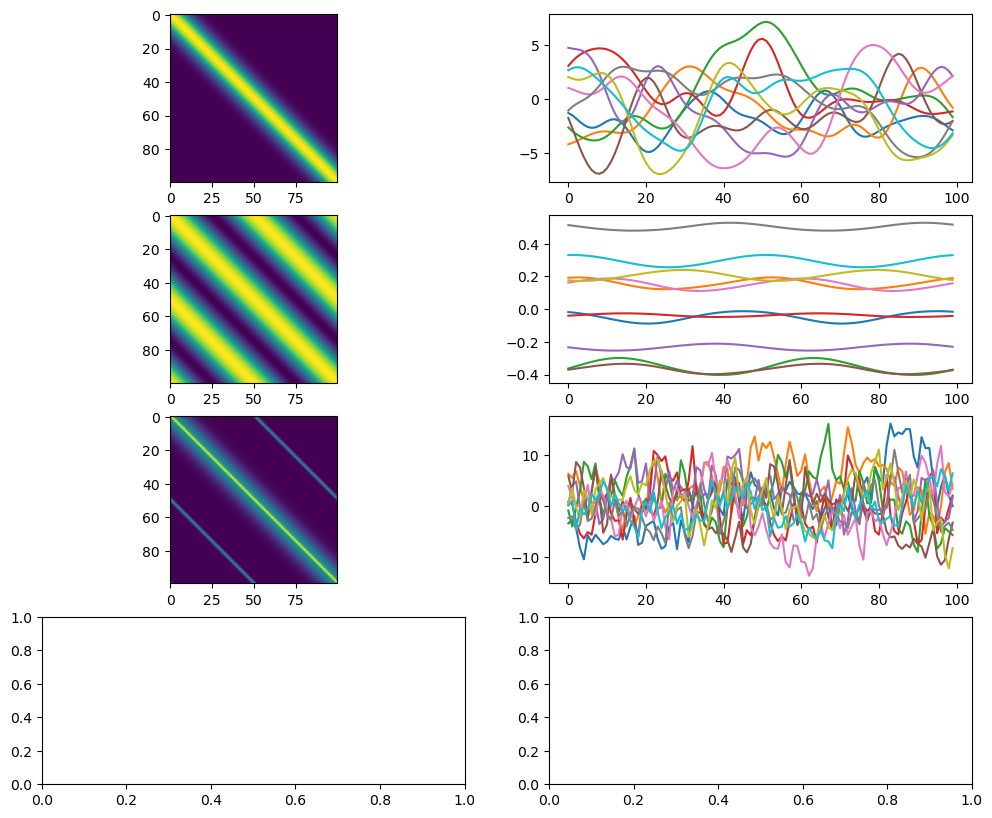

In [463]:
# Setting up figure axes 
fig, axes = plt.subplots(4, 2, figsize=(12, 10)) 
axes = axes.ravel() 

# General parameters 
X = np.arange(0, 100, 1).reshape(-1, 1)
mu = np.zeros(shape=len(X))
lengthscale = 10
variance = 10
period = 50
roughness = 0.1

data = { 
    'dataset': X, 
    'mean_vector': mu,
    'observations': [], 
}


kern = exponential_kernel(lengthscale, variance)
K = kern(X) 
_ = axes[0].imshow(K)

samps = np.random.multivariate_normal(mu, K, 10) 
_ = axes[1].plot(X.flatten(), samps.T)


kern = periodic_kernel(variance, period, roughness)
K  = kern(X) 
_ = axes[2].imshow(K) 

samps = np.random.multivariate_normal(mu, K, 10) 
_ = axes[3].plot(X.flatten(), samps.T)


kern = exponential_kernel(lengthscale, variance) + periodic_kernel(roughness, period, variance)
K = kern(X) 
_ = axes[4].imshow(K)

samps = np.random.multivariate_normal(mu, K, 10) 
_ = axes[5].plot(X.flatten(), samps.T)

In [474]:
theta0 = 50
starts = np.array([0, 100, 200])
lam = 0.05
dt = 0.1
obs_interval = 15
t = 60 * 24
sigma_theta = 0.3
min_threshold = sigma_theta
sim = RegularIrrigationSim(theta0, starts, lam, sigma_theta)
obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

(287, 19)
(19, 19)


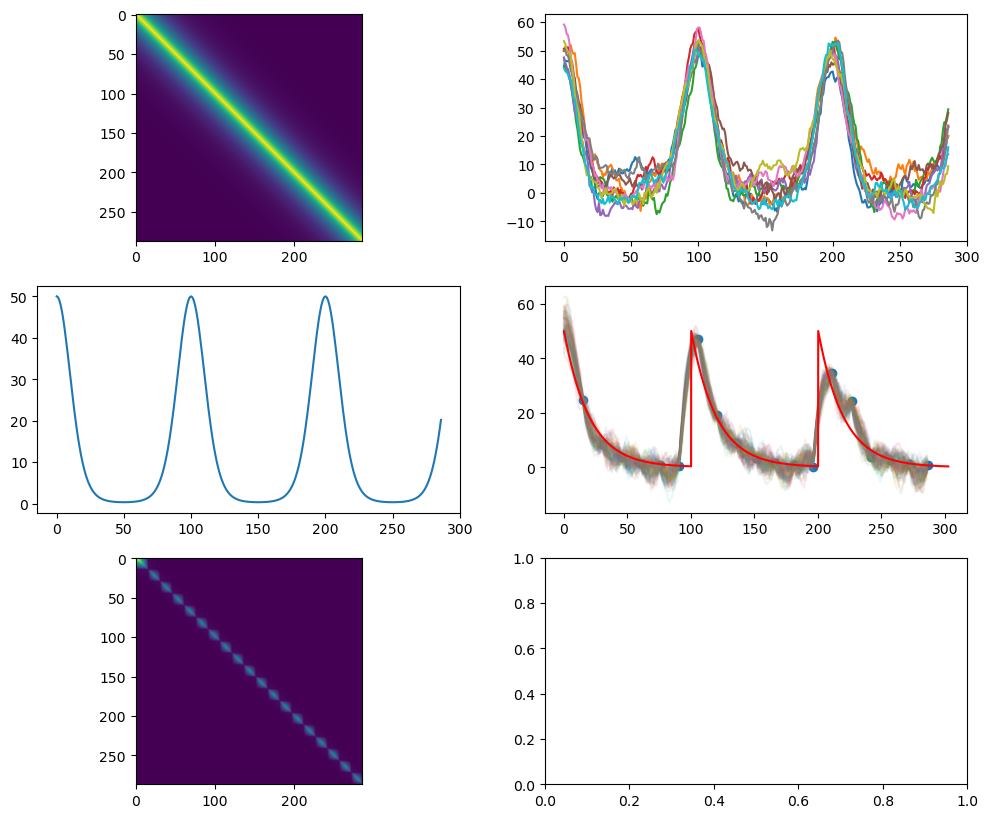

In [504]:
Xobs = np.array(sim.data['observed']['t'])
Y = sim.data['observed']['y']
X = np.arange(0, max(Xobs), 1).reshape(-1, 1)
Xobs = Xobs.reshape(-1, 1)

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel() 


A = 50
a = 0.05
T = 100
mean_func = mean_function(A, a, T).exponential_period


lengthscale = 1
variance = 1
period = 100
roughness = 10

kern = decay_kernel(variance=20, decay_rate=0.05) + periodic_kernel(roughness=roughness, period=period, variance=variance)

K = kern(X) 
p_mu = mean_func(X)

samps = np.random.multivariate_normal(p_mu.flatten(), K, 10)
_ = axes[0].imshow(K)
_ = axes[1].plot(X.flatten(), samps.T)
_ = axes[2].plot(X.flatten(), p_mu)

posterior = gaussian_posterior(Xobs, X, Y, noise=0.5, kernel=kern, mean_function=mean_func)
mean, cov = posterior.return_posterior() 

samps = np.random.multivariate_normal(mean, cov, 100) 
_ = axes[3].plot(X.flatten(), samps.T, alpha=0.1)
_ = axes[3].scatter(Xobs.flatten(), Y)


axes[3].plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
axes[4].imshow(cov)


In [580]:
X = np.random.normal(3, 3, 100000)

integral = 6 * (1 / len(X)) * np.sum(X) 

print(integral) 

17.92565655201125
